# PART 1 - INITIALIZE

## Import packages

In [52]:
# %reset -f # Clear all variables

# LINC API
import hackathon_linc as lh
lh.init('92438482-5598-4e17-8b34-abe17aa8f598') # Authenticate and connect to API

# For data handling
import pandas as pd
import numpy as np
from datetime import datetime, time

# For plotting
import hvplot.pandas
import holoviews as hv

# For shared data
import shared

# Miscellaneous
import sys
import os
from functions.metrics import calculate_rsi, calculate_moving_average, calculate_moving_std



    Welcome to the LINC Hackathon! Your token is now saved in the Console. 
    That means you don't need to carry that out when using the other functions
    as long as you don't close your console. 
    
    This function is only to be used once to authenticate your token.
    
    Happy coding!

    


In [40]:
# Fetch starting balance
start_balance = lh.get_balance()
print(f"Starting balance: {start_balance}")

Starting balance: 1001181.47


## Save data to shared (for testing)

In [33]:
CSV_file_path = 'stockPrices_hourly.csv' 

# Read historical data
df = pd.read_csv(f'historical_data/{CSV_file_path}')


# Add date column and convert date columns to datetime
df['gmtTime'] = pd.to_datetime(df['gmtTime'])
df['date'] = pd.to_datetime(df['gmtTime'].dt.date)

# Add averaged price and volume columns
df['price'] = (df['askMedian'] + df['bidMedian']) / 2

# Sort values
df = df.sort_values(by=['symbol', 'gmtTime'])

# **Maintain rolling window**
max_rows = np.inf
if len(df) > max_rows:
    df = df.iloc[-max_rows:]  # Keep only last max_rows entries

# Aggregate daily open and close prices (assumes historical data contains full days)
df_daily = df.groupby(['symbol', 'date']).agg(
    openPrice=('price', 'first'),  # First price of the day
    closePrice=('price', 'last'),  # Last price of the day
    askVolume=('askVolume', 'sum'), # Sum ask volume over the entire day
    bidVolume=('bidVolume', 'sum') # Sum bid volume over the entire day
).reset_index()

# Sort values
df_daily = df_daily.sort_values(by=['symbol', 'date'])

# **Save dataframes to shared data**
shared.shared_data['df'] = df
shared.shared_data['df_daily'] = df_daily

print(f"Columns in hourly DataFrame: {list(shared.shared_data['df'].columns)}")
print(f"Columns in daily DataFrame: {list(shared.shared_data['df_daily'].columns)}")
print(f"Stocks: {list(shared.shared_data['df']['symbol'].unique())}")
print("------Hourly DataFrame------")
shared.shared_data['df_daily'].head()

Columns in hourly DataFrame: ['gmtTime', 'askMedian', 'bidMedian', 'askVolume', 'bidVolume', 'spreadMedian', 'symbol', 'date', 'price']
Columns in daily DataFrame: ['symbol', 'date', 'openPrice', 'closePrice', 'askVolume', 'bidVolume']
Stocks: ['STOCK1', 'STOCK10', 'STOCK2', 'STOCK3', 'STOCK4', 'STOCK5', 'STOCK6', 'STOCK7', 'STOCK8', 'STOCK9']
------Hourly DataFrame------


,symbol,date,openPrice,closePrice,askVolume,bidVolume
0,STOCK1,2015-04-22,75.044183,74.614952,3463.198384,3029.416667
1,STOCK1,2015-04-23,74.012842,73.083283,3647.883330,3160.283333
2,STOCK1,2015-04-24,73.969575,74.442367,3400.016668,2829.133333
3,STOCK1,2015-04-27,74.574558,76.217919,2875.623656,2411.539787
4,STOCK1,2015-04-28,76.372558,76.192233,2067.436780,1647.533333


# Calculate hourly daily and percentage change

In [ ]:
df['pct_change'] = df['price'].pct_change(periods=1)
df_daily['pct_change'] = (df_daily['close_price'] - df_daily['open_price']) / df_daily['open_price'] * 100

# PART 2: STRATEGY

## Markowitz optimal portfolio 
$$
\max_\omega \; \omega^\top \mu - \lambda \omega^\top \Sigma \omega \\
\sum \omega_i = 1 \\
\omega_i \geq 0
$$

## Calculate $\mu$ and $\Sigma$

In [50]:
# Calculate log returns
df_daily['log_return'] = df_daily.groupby('symbol', group_keys=False)['openPrice'].transform(lambda x: np.log(x / x.shift(1)))
df_daily.dropna(inplace=True)

# Pivot table to get returns in matrix form (rows = dates, cols = assets)
returns_df = df_daily.pivot(index='date', columns='symbol', values='log_return')

# Compute mean returns and covariance matrix
mu = returns_df.mean().values  # Expected returns (mean of each column)
Sigma = returns_df.cov().values  # Covariance matrix

print(list(returns_df.columns))

['STOCK1', 'STOCK10', 'STOCK2', 'STOCK3', 'STOCK4', 'STOCK5', 'STOCK6', 'STOCK7', 'STOCK8', 'STOCK9']


## Solve optimization problem

In [51]:
from scipy.optimize import minimize

# Risk aversion parameter (adjust as needed)
lambda_ = 0.5  # Higher value means more risk aversion

# Number of assets
n_assets = len(mu)

# Initial guess: Equal weights
w0 = np.ones(n_assets) / n_assets  

# Constraints: Sum of weights = 1
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

# Bounds: Ensure weights are non-negative (no short selling)
bounds = [(0, 1)] * n_assets

# Define the objective function to minimize (negative of our function)
def objective(w, mu, Sigma, lambda_):
    return - (np.dot(w, mu) - lambda_ * np.dot(w.T, np.dot(Sigma, w)))

# Solve the optimization
result = minimize(objective, w0, args=(mu, Sigma, lambda_), 
                  method='SLSQP', bounds=bounds, constraints=constraints)

# Extract optimal weights
optimal_weights = result.x

print("Optimal Portfolio Weights:", optimal_weights)


Optimal Portfolio Weights: [5.11060295e-01 1.08853898e-16 9.36750677e-17 0.00000000e+00
 5.98479599e-17 2.29850861e-16 2.42861287e-16 2.04644316e-01
 2.84295390e-01 1.73472348e-16]


In [36]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Sample df_daily (ensure it has 'date', 'symbol', and 'log_return' columns)
# df_daily = ...

# Set up rolling window parameters
window_size = 252  # Use past 252 days for each optimization
rebalance_freq = 30  # Re-optimize every 30 days

# Get unique sorted dates
dates = sorted(df_daily['date'].unique())

# Initialize dictionary to store optimal weights over time
portfolio_weights = {}

# Define Markowitz objective function
def markowitz_objective(w, mu, Sigma, lambda_):
    return - (np.dot(w, mu) - lambda_ * np.dot(w.T, np.dot(Sigma, w)))

# Iterate over rolling windows
for i in range(window_size, len(dates), rebalance_freq):
    start_date = dates[i - window_size]
    end_date = dates[i]
    
    # Get data for the rolling window
    df_window = df_daily[(df_daily['date'] >= start_date) & (df_daily['date'] < end_date)]
    
    # Compute expected returns (mean log returns per stock)
    mu = df_window.groupby('symbol')['log_return'].mean().values
    
    # Compute covariance matrix of log returns
    Sigma = df_window.pivot(index='date', columns='symbol', values='log_return').cov().values
    
    # Number of stocks
    num_assets = len(mu)
    
    # Initial weights (equal allocation)
    w0 = np.ones(num_assets) / num_assets

    # Bounds (weights between 0 and 1)
    bounds = [(0, 1) for _ in range(num_assets)]

    # Constraint: Sum of weights must be 1
    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

    # Solve the optimization
    result = minimize(markowitz_objective, w0, args=(mu, Sigma, 0.5), 
                      method='SLSQP', bounds=bounds, constraints=constraints)

    # Store optimal weights
    portfolio_weights[end_date] = result.x

    print(f"Optimized portfolio on {end_date}: {result.x}")

# Convert results to DataFrame
df_portfolio_weights = pd.DataFrame.from_dict(portfolio_weights, orient='index')

print("\nFinal Portfolio Weights over time:")
print(df_portfolio_weights)


Optimized portfolio on 2016-04-21 00:00:00: [1.00000000e+00 4.63171168e-16 0.00000000e+00 6.93889390e-18
 3.59087760e-16 8.67361738e-18 1.28369537e-16 0.00000000e+00
 0.00000000e+00 1.30104261e-16]
Optimized portfolio on 2016-06-03 00:00:00: [1.00000000e+00 6.07153217e-18 0.00000000e+00 0.00000000e+00
 2.35922393e-16 2.04263689e-16 0.00000000e+00 2.15105711e-16
 0.00000000e+00 8.93382590e-17]
Optimized portfolio on 2016-07-15 00:00:00: [1.00000000e+00 6.41847686e-17 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.96782694e-16 5.37764278e-17 2.77555756e-16
 1.49186219e-16 0.00000000e+00]
Optimized portfolio on 2016-08-26 00:00:00: [1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.73472348e-17 0.00000000e+00 2.08166817e-17
 0.00000000e+00 0.00000000e+00]
Optimized portfolio on 2016-10-10 00:00:00: [1.00000000e+00 0.00000000e+00 2.41126563e-16 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.03576608e-17 1.66533454e-16
 7.71951947e-17 1.21430643e-17]
Optimized 

## See performance

Final Portfolio Value: $100,000.00
Percentage gain: 0.00%


<Axes: title={'center': 'Portfolio Value Over Time'}>

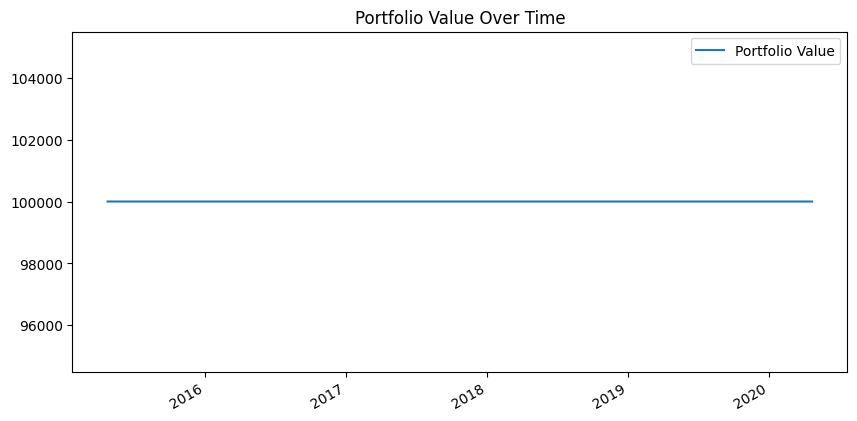

In [45]:
# Assume `df_portfolio_weights` contains portfolio weights indexed by rebalance date
# Assume `df_daily` contains 'date', 'symbol', and 'log_return' columns

# Set initial balance
initial_balance = 100000  # Start with $100,000

# Get sorted unique dates
dates = sorted(df_daily['date'].unique())

# Convert portfolio weights DataFrame to a dictionary for easy lookup
portfolio_weights_dict = df_portfolio_weights.to_dict(orient='index')

# Convert all rebalance dates and df_daily dates to datetime
portfolio_weights_dict = {pd.to_datetime(k): v for k, v in portfolio_weights_dict.items()}
dates = pd.to_datetime(dates)


# Initialize portfolio value tracking
portfolio_value = {dates[0]: initial_balance}
portfolio_returns = []

# Iterate over dates to compute returns
for i in range(1, len(dates)):
    current_date = dates[i]
    prev_date = dates[i-1]

    # Find the most recent rebalance date
    valid_rebalance_dates = [d for d in portfolio_weights_dict.keys() if d <= prev_date]

    if valid_rebalance_dates:
        last_rebalance_date = max(valid_rebalance_dates)
    else:
        print(f"Warning: No rebalance date found before {prev_date}. Using first available.")
        last_rebalance_date = min(portfolio_weights_dict.keys())  # Use first rebalance date as fallback

    weights = np.array(list(portfolio_weights_dict[last_rebalance_date].values()))

    # Get stock returns for current day
    daily_returns = df_daily[df_daily['date'] == current_date].set_index('symbol')['log_return']

    # Ensure stock order matches weights order
    daily_returns = daily_returns.reindex(df_portfolio_weights.columns).fillna(0).values

    # Compute portfolio return for the day
    portfolio_return = np.dot(weights, daily_returns)
    portfolio_returns.append(portfolio_return)

    # Compute new portfolio value
    portfolio_value[current_date] = portfolio_value[prev_date] * np.exp(portfolio_return)

# Convert portfolio values to DataFrame
df_portfolio_value = pd.DataFrame.from_dict(portfolio_value, orient='index', columns=['Portfolio Value'])

# Print final portfolio value
print(f"Final Portfolio Value: ${df_portfolio_value.iloc[-1, 0]:,.2f}")
print(f"Percentage gain: {(df_portfolio_value.iloc[-1, 0] - initial_balance)/ initial_balance:.2f}%")

# Display portfolio value over time
df_portfolio_value.plot(title="Portfolio Value Over Time", figsize=(10, 5))
